Plug-and-Play ADMM Demosaicing
==============================

This example demonstrates the use of class [admm.ppp.PPP](http://sporco.rtfd.org/en/latest/modules/sporco.admm.ppp.html#sporco.admm.ppp.PPP) for solving a raw image demosaicing problem.

In [1]:
from __future__ import print_function
from builtins import input, range

import numpy as np
from scipy.sparse.linalg import LinearOperator

from bm3d import bm3d_rgb

from sporco.linalg import _cg_wrapper
from sporco.admm.ppp import PPP
from sporco.interp import bilinear_demosaic
from sporco import metric
from sporco import util
from sporco import plot
plot.config_notebook_plotting()

Define demosaicing forward operator and its transpose.

In [2]:
def A(x):
    """Map an RGB image to a single channel image with each pixel
    representing a single colour according to the colour filter array.
    """

    y = np.zeros(x.shape[0:2])
    y[1::2, 1::2] = x[1::2, 1::2, 0]
    y[0::2, 1::2] = x[0::2, 1::2, 1]
    y[1::2, 0::2] = x[1::2, 0::2, 1]
    y[0::2, 0::2] = x[0::2, 0::2, 2]
    return y


def AT(x):
    """Back project a single channel raw image to an RGB image with zeros
    at the locations of undefined samples.
    """

    y = np.zeros(x.shape + (3,))
    y[1::2, 1::2, 0] = x[1::2, 1::2]
    y[0::2, 1::2, 1] = x[0::2, 1::2]
    y[1::2, 0::2, 1] = x[1::2, 0::2]
    y[0::2, 0::2, 2] = x[0::2, 0::2]
    return y

Load reference image.

In [3]:
img = util.ExampleImages().image('kodim23.png', scaled=True,
                                 idxexp=np.s_[160:416,60:316])

Construct test image constructed by colour filter array sampling and adding Gaussian white noise.

In [4]:
np.random.seed(12345)
s = A(img)
rgbshp = s.shape + (3,)  # Shape of reconstructed RGB image
rgbsz = s.size * 3       # Size of reconstructed RGB image
nsigma = 2e-2            # Noise standard deviation
sn = s + nsigma * np.random.randn(*s.shape)

Define data fidelity term for PPP problem.

In [5]:
def f(x):
    return 0.5 * np.linalg.norm((A(x) - sn).ravel())**2

Define proximal operator of data fidelity term for PPP problem.

In [6]:
def proxf(x, rho, tol=1e-3, maxit=100):
    ATA = lambda z: AT(A(z))
    ATAI = lambda z: ATA(z.reshape(rgbshp)).ravel() + rho * z.ravel()
    lop = LinearOperator((rgbsz, rgbsz), matvec=ATAI, dtype=s.dtype)
    b = AT(sn) + rho * x
    vx, cgit = _cg_wrapper(lop, b.ravel(), None, tol, maxit)
    return vx.reshape(rgbshp)

Define proximal operator of (implicit, unknown) regularisation term for PPP problem. In this case we use BM3D [[12]](http://sporco.rtfd.org/en/latest/zreferences.html#dabov-2008-image) as the denoiser, using the [code](https://pypi.org/project/bm3d) released with [[28]](http://sporco.rtfd.org/en/latest/zreferences.html#makinen-2019-exact).

In [7]:
bsigma = 7.5e-2  # Denoiser parameter

def proxg(x, rho):
    return bm3d_rgb(x, bsigma)

Construct a baseline solution and initaliser for the PPP solution by BM3D denoising of a simple bilinear demosaicing solution. The `3 * nsigma` denoising parameter for BM3D is chosen empirically for best performance.

In [8]:
imgb = bm3d_rgb(bilinear_demosaic(sn), 3 * nsigma)

Set algorithm options for PPP solver, including use of bilinear demosaiced solution as an initial solution.

In [9]:
opt = PPP.Options({'Verbose': True, 'RelStopTol': 1e-3,
                   'MaxMainIter': 10, 'rho': 1.5e-1, 'Y0': imgb})

Create solver object and solve, returning the the demosaiced image ``imgp``.

In [10]:
b = PPP(img.shape, f, proxf, proxg, opt=opt)
imgp = b.solve()

Itn   FVal      r         s       
----------------------------------


   0  4.44e-01  3.15e-02  4.38e-01


   1  1.95e+00  2.38e-02  2.69e-01


   2  3.14e+00  1.71e-02  2.08e-01


   3  4.11e+00  1.43e-02  1.71e-01


   4  4.87e+00  1.30e-02  1.29e-01


   5  5.45e+00  1.20e-02  8.72e-02


   6  5.97e+00  1.05e-02  5.73e-02


   7  6.48e+00  8.50e-03  4.76e-02


   8  6.98e+00  6.77e-03  4.79e-02


   9  7.46e+00  5.82e-03  4.53e-02
----------------------------------


Display solve time and demosaicing performance.

In [11]:
print("PPP ADMM solve time:        %5.2f s" % b.timer.elapsed('solve'))
print("Bilinear demosaicing PSNR:  %5.2f dB" % metric.psnr(img, imgb))
print("PPP demosaicing PSNR:       %5.2f dB" % metric.psnr(img, imgp))

PPP ADMM solve time:        40.68 s
Bilinear demosaicing PSNR:  30.66 dB
PPP demosaicing PSNR:       36.98 dB


Display reference and demosaiced images.

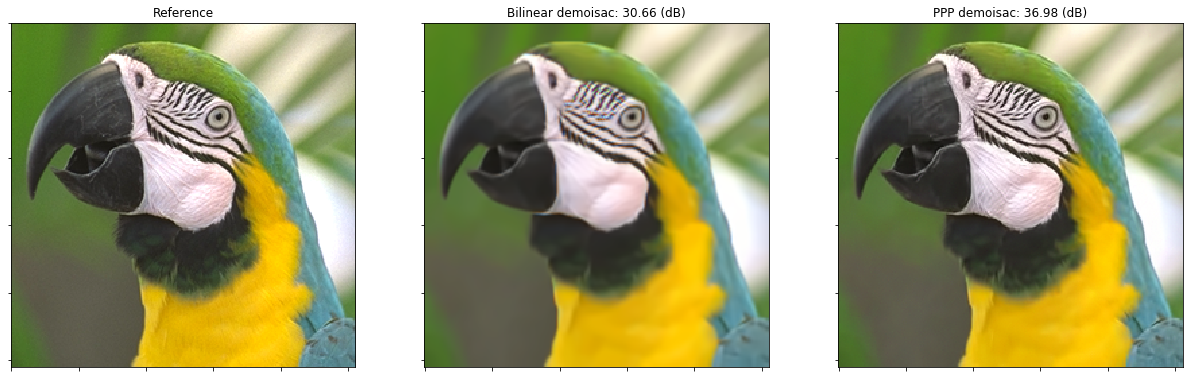

In [12]:
fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=True,
                        figsize=(21, 7))
plot.imview(img, title='Reference', fig=fig, ax=ax[0])
plot.imview(imgb, title='Bilinear demoisac: %.2f (dB)' %
            metric.psnr(img, imgb), fig=fig, ax=ax[1])
plot.imview(imgp, title='PPP demoisac: %.2f (dB)' %
            metric.psnr(img, imgp), fig=fig, ax=ax[2])
fig.show()